# 30 Days Readmission 

##  Libraries

In [1]:
import sqlite3 
import pandas as pd
import numpy as np
import pacmap
from sklearn.model_selection import cross_val_score, train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix

import time
import math

import warnings
warnings.filterwarnings('ignore')

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc
from scipy import interp
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import PowerTransformer
import os
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from datetime import datetime as dt
import itertools
import pacmap
%matplotlib inline


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc
#import all relevant libraries
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc
from scipy import interp

from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import KFold
from tqdm import tqdm
from sklearn.linear_model import Lasso
%matplotlib inline
from sklearn.metrics import f1_score

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [978]:
colores_circulo = ['#213FAF','#E7B341','#5AA264','#6E3DFF','#00ABFA',
                   '#00FF58','#C03EF0','#0BE3C1','#FF7ACC','#D4FD53']

sns.set_theme('paper','darkgrid',font_scale=1.3,rc={'font.family':'Helvetica Neue','axes.facecolor':'#E5ECF6'})
sns.set_palette(sns.color_palette(colores_circulo))

In [979]:
pd.set_option('display.max_columns', None)

# Response variable

Read csv prepo data which is already selecetd(subset)

In [980]:

def label_fun(days):
    '''Funcion que obtiene las readmissiones que son mayores a un numero de dias '''
    '''input
    days: numero de dias los cuales se consideran como una readmission
    return: regresa un dataframe donde se tiene los intervalos de visita y ultima visitam como el rankeo de las visitas y las etiqueta de 
    readimission.
    '''
    # Admissions 
    ADMISSIONS = pd.read_csv("/Users/cgarciay/Desktop/Laval_Master_Computer/research/data_preprocess.csv")


    #the dataframe is ranked, by admission time, 
    a = ADMISSIONS[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME']]
    a['ADMITTIME_RANK'] = a.groupby('SUBJECT_ID')['ADMITTIME'].rank(method='first')

    # The last admission date is obtained
    b = a.groupby('SUBJECT_ID')['ADMITTIME_RANK'].max().reset_index()
    b.rename(columns={'ADMITTIME_RANK': 'MAX_ADMITTIME_RANK'}, inplace=True)

    #Each rank matches the max rank
    readmit_df = pd.merge(a, b, on='SUBJECT_ID', how='left')

    # date types are changed
    readmit_df[['ADMITTIME','DISCHTIME']] = readmit_df[['ADMITTIME','DISCHTIME']].apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S'))
    # readmission is sorted descending considering the admission time

    readmit_df = readmit_df.sort_values(by=['SUBJECT_ID', 'ADMITTIME'])


    # the label is shifted one, to obtain the next  amission addtime, the fist admission time is appended in the end
    next_admittime= readmit_df['ADMITTIME'].values[1:]
    # The fist label is appende in the last to have the  same dimension but it does not matter because the las label is the max of the subject so it will no be taken into account
    next_admittime = np.append(next_admittime, next_admittime[0])
    readmit_df['NEXT_ADMITTIME'] = next_admittime
    readmit_df['NEXT_ADMITTIME'].shape

    # we star with label as -1

    readmit_df[days +'_READMIT'] = -1
    # if the rank is equal to the max the its considered as las admission and there is no readmission
    readmit_df.loc[readmit_df['ADMITTIME_RANK'] == readmit_df['MAX_ADMITTIME_RANK'], days+'_READMIT'] = 0
    # to analyse does that are possible readmission we filter the ones left -1
    readmit_sub_df = readmit_df[readmit_df[days +'_READMIT']==-1]
    print(readmit_sub_df.shape)

    # the interval of day between next admission and the actual discharfe time is obatain
    interval = (readmit_sub_df['NEXT_ADMITTIME'] - readmit_sub_df['DISCHTIME']).dt.days.values

    # if it lower than n days then it would be readmission 0 otherwise
    readmit_df.loc[readmit_df[days+'_READMIT']==-1, 'INTERVAL'] = interval 

    readmit_df.loc[readmit_df['INTERVAL']<=int(days), days+'_READMIT'] = 1
    readmit_df.loc[readmit_df['INTERVAL']>int(days),  days+'_READMIT'] = 0
    readmit_df.to_csv("/Users/cgarciay/Desktop/Laval_Master_Computer/research/y_readmission_label/label_"+days+"j.csv")
    return readmit_df

# Función de preprocesing


In [981]:


def preprocess(X, prep):
    '''function that obtaines the variable predictor, it has 3 types of preprocesing, standard, mas and powe,'''
    '''input:X the variables predictors and the type of preprocesing in string
    return: a X withe the preprocesing appplied'''
    if prep  == "std":
        
        data = X.values
        scaler = StandardScaler()
        scaler.fit(data)
        X = scaler.transform(data)
        print(X)
        print(X.shape)
        
    elif prep ==  "max":
                
        transformer = MaxAbsScaler().fit(X)
        X = transformer.transform(X)
        print(X.shape)
        print(X)
    elif prep == "power":
        numerical = X.select_dtypes(exclude='object')

        for c in numerical.columns:
            pt = PowerTransformer()
            numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
            X = numerical.copy()
            print(X.shape)
    else:
        X =X        
            
    return X        


# Leer Variables , creación

In [982]:

def read_director(ejemplo_dir):
    'Function that give you all the files int and archive'
    with os.scandir(ejemplo_dir) as ficheros:
        ficheros = [fichero.name for fichero in ficheros if fichero.is_file()]
    print(ficheros)
    
    
    
    return [i for i in ficheros if i!= '.DS_Store']

In [983]:
def lectura_variables(readmit_df,fichero_x,fichero_y,prepo,ejemplo_dir,days):
    '''Funtion tha reads the predictor dataset and  it eliminates the unwanteed columns and preprocess the dataset, also it concatenates de 
    response variable to obtain only the visits that are in the X datase,
    fichero_x: the file that will be reading the input from
    fichero_y: the y labl
    ejemplo_dir: directorio donde se encuentra el input para la prediccion
    days: cuantos dias se esta considerando prediccion
    prepo: type of prepro that is required
    outputs:
    X: the preprossed variables
    y: the label'''
  
    #read the pandas file
    X_aux = pd.read_csv(ejemplo_dir+fichero_x)
    
    # if its no ber embeddinf we do the preprocessinfg
    if fichero_x != 'clinicalBertembedding.csv':
        # read the lable file
        #readmit_df = pd.read_csv(ejemplo_dir2+fichero_y)
        #The X dataset and the y is merged only considering the visits that are in X, so the dimension of y match
        concat_var = pd.merge(X_aux, readmit_df[["HADM_ID","SUBJECT_ID",days+'_READMIT']], on=["HADM_ID","SUBJECT_ID"], how='left')
        y = concat_var[[days+'_READMIT']]
        print(concat_var.shape )
        # The variables that are no considered as predictores are dropped, 
        X = concat_var.drop(["HADM_ID","SUBJECT_ID",days+'_READMIT','L_1s_last','Unnamed: 0','L_1s_last_p1'], axis=1)
        # the preprocessing is obtained 
        X = preprocess(X, prepo)
    else:
        # the same procedures is done except that no considered preprocesing for bert embedding
        #readmit_df = pd.read_csv(ejemplo_dir2+fichero_y)
        concat_var = pd.merge(X_aux, readmit_df[["HADM_ID","SUBJECT_ID",days+'_READMIT']], on=["HADM_ID","SUBJECT_ID"], how='left')
        y = concat_var[[days+'_READMIT']]
        print(concat_var.shape )
        X = concat_var.drop(["HADM_ID","SUBJECT_ID",days+'_READMIT','Unnamed: 0','L_1s_last_p1','L_1s_last'], axis=1)


        
    return X,y ,concat_var


In [984]:
days = "30"
ejemplo_dir = '/Users/cgarciay/Desktop/Laval_Master_Computer/research/input_model_pred/'
fichero_x = ficheros[2]
#ejemplo_dir2 = '/Users/cgarciay/Desktop/Laval_Master_Computer/research/y_readmission_label/'
fichero_y ="label_"+days+"j.csv"
prepo = "std"
readmit_df = label_fun(days)
X,y ,concat_var  = lectura_variables(readmit_df,fichero_x,fichero_y,prepo,ejemplo_dir)

(12456, 8)


TypeError: lectura_variables() missing 1 required positional argument: 'days'

In [ ]:
print('number of instance : the number features = {}'.format(X.shape[1]) )
readmit_df[days+"_READMIT"].value_counts()/readmit_df[days+"_READMIT"].shape

number of instance : the number features = 700


0    0.825539
1    0.174461
Name: 30_READMIT, dtype: float64

# EDA 

In [ ]:
def create_var(ejemplo_dir,fichero_x):
    X_aux = pd.read_csv(ejemplo_dir+fichero_x)
    concat_var_ = pd.merge(X_aux, readmit_df, on=["HADM_ID","SUBJECT_ID"], how='left')
    #create bin for interval and group age and, lengh of tay
    concat_var_ = create_bins_fun(concat_var_)
    return concat_var_
    

In [ ]:
readmit_df = label_fun(days)
ejemplo_dir = '/Users/cgarciay/Desktop/Laval_Master_Computer/research/input_model_pred/'
ficheros = read_director(ejemplo_dir)

X,y ,concat_var  = lectura_variables(readmit_df,fichero_x,fichero_y,prepo,ejemplo_dir)


(12456, 8)
['sin_codigo.csv', 'cat_threshold .999 most frequent.csv', '.DS_Store', 'cat_threshold .98 most frequent.csv', 'cat_threshold .95 most frequent_proc.csv', 'cat_threshold .88 most frequent.csv', 'ICD9_CODE_procedures.csv', 'CCS CODES_proc.csv']


TypeError: lectura_variables() missing 1 required positional argument: 'days'

## Label


In [ ]:
y

array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [ ]:
per_readmission(y)

funcion_histograma_porotra_variable(concat_var_,days+'_READMIT','ADMITTIME',"Admission","Date of admission by readmission","Admission")


AttributeError: 'numpy.int64' object has no attribute 'values'

In [ ]:
concat_var_.columns[-20:]

Index(['9971.0', '9972.0', '9977.0', '9983.0', 'SUBJECT_ID', 'HADM_ID',
       'Age_max', 'LOSRD_sum', 'L_1s_last', 'LOSRD_avg', 'L_1s_last_p1',
       'ADMITTIME', 'DISCHTIME', 'ADMITTIME_RANK', 'MAX_ADMITTIME_RANK',
       'NEXT_ADMITTIME', '30_READMIT', 'INTERVAL', 'age_group',
       'INTERVAL_group'],
      dtype='object')

## Predictors

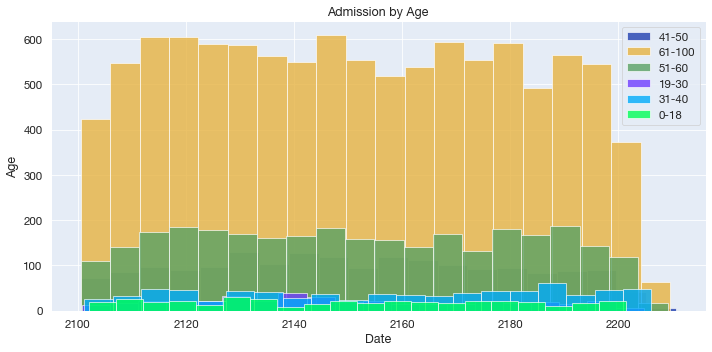

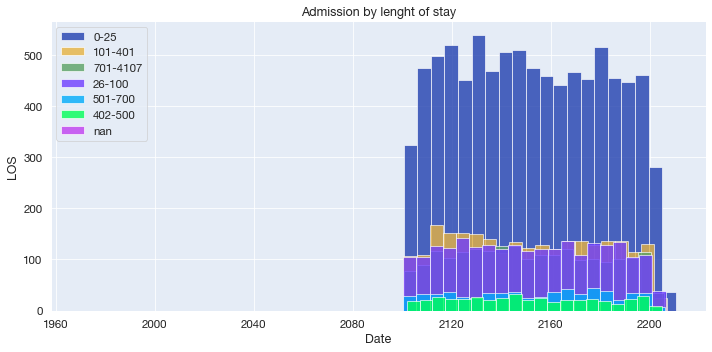

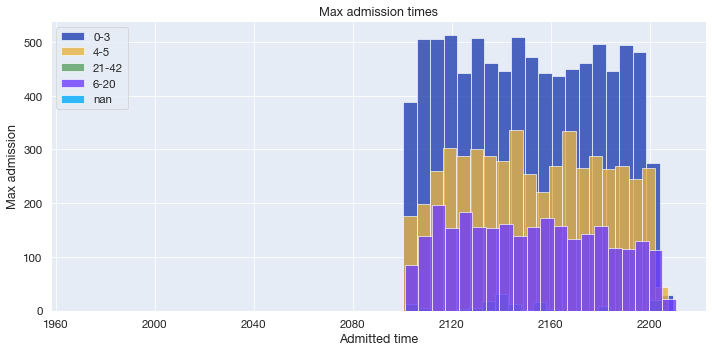

In [ ]:
funcion_histograma_porotra_variable(concat_var_,'age_group','ADMITTIME',"Date","Admission by Age", "Age")
funcion_histograma_porotra_variable(concat_var_,'INTERVAL_group','ADMITTIME',"Date","Admission by lenght of stay", "LOS")
funcion_histograma_porotra_variable(concat_var_,"INTERVAL_max_admitted","ADMITTIME","Admitted time","Max admission times","Max admission")


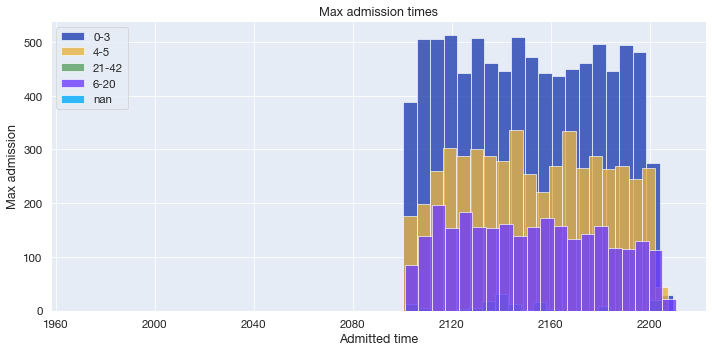

In [ ]:
 = concat_var_[concat_var_["ADMITTIME"]>pd.to_datetime(2120)]
auxfuncion_histograma_porotra_variable(aux,"INTERVAL_max_admitted","ADMITTIME","Admitted time","Max admission times","Max admission")


## Predictors with labels

### Demographics, **only once runned**

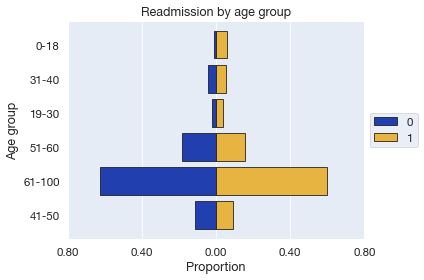

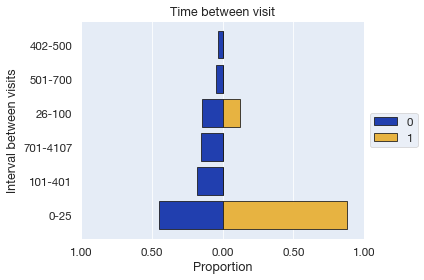

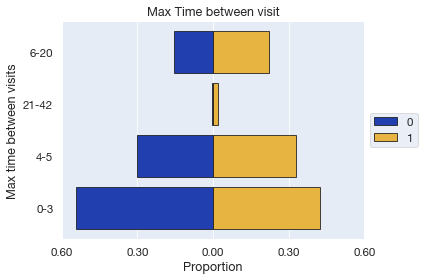

In [ ]:
proporcion_dos_var('age_group',days+'_READMIT',concat_var_,'Readmission by age group', 'Age group','Proportion')
proporcion_dos_var('INTERVAL_group',days+'_READMIT',concat_var_[concat_var_['INTERVAL_group'].notnull()],'Time between visit', 'Interval between visits','Proportion')
proporcion_dos_var('INTERVAL_max_admitted',days+'_READMIT',concat_var_[concat_var_['INTERVAL_max_admitted'].notnull()],'Max Time between visit', 'Max time between visits','Proportion')


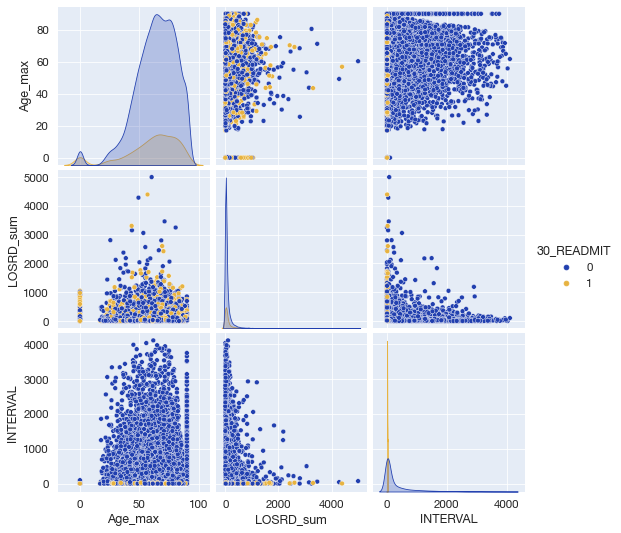

In [ ]:
demo = ["Age_max",'LOSRD_sum','INTERVAL', 'age_group'
       ,days+'_READMIT']
demo1 = ["Age_max",'LOSRD_sum','INTERVAL', ]
sns.pairplot(concat_var_[demo] , hue=days+'_READMIT')
plt.show()

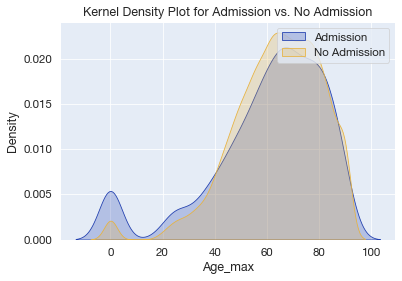

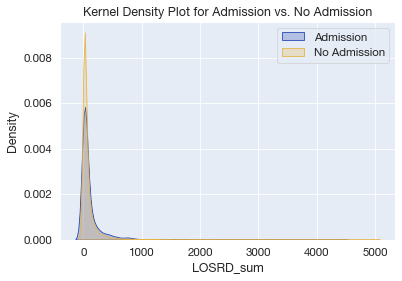

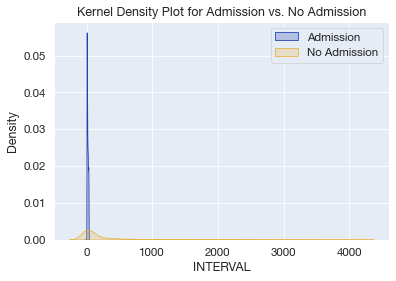

In [ ]:
for i in demo1:
    
    kernel_density_plot(i,concat_var_,'Kernel Density Plot for Admission vs. No Admission')

##### embeddings con demograficos

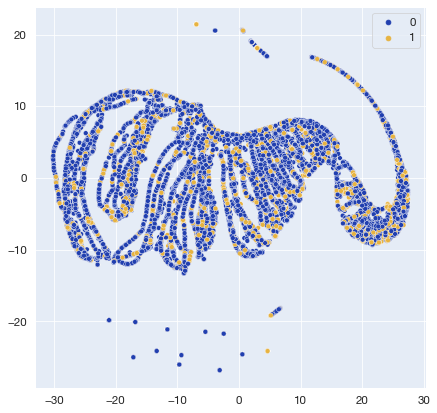

In [ ]:
embedding_pac_y(days,concat_var,True)


##### embedding sin demograficos

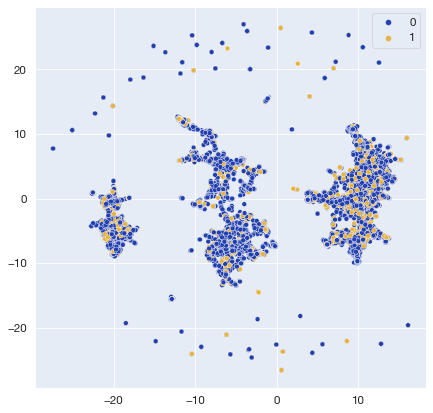

In [ ]:
embedding_pac_y(days,concat_var,"FALSE")

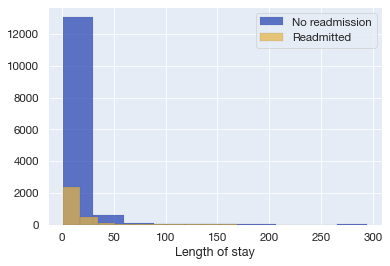

In [ ]:
variables_predictoras(concat_var_,"LOSRD_avg")

### Run for each mapping



In [ ]:
cols1 = [i for i in filtered_columns_icd9codes if i !=days +"_READMIT"]
#PACMAP EMBEDDING CONSITHEINGT HE COLUMNS THAT ARE MOS 
#X_transformed = pac_embeddng(filtered_columns_icd9codes[cols1],filtered_columns_icd9codes,path,namep_)

embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 


In [ ]:
 concat_var_[days+"_READMIT"].values

array([0, 0, 0, ..., 1, 1, 0])

In [ ]:
filtered_columns,max_sum_icd9codes,filtered_columns_icd9codes = top_predictors(concat_var_,10,"sum")
cols1 = [i for i in filtered_columns_icd9codes if i !=days +"_READMIT"]


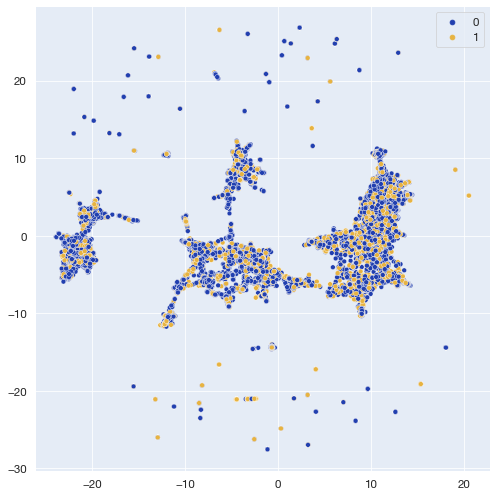

In [ ]:
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 

# fit the data (The index of transformed data corresponds to the index of the original data)
X_transformed = embedding.fit_transform(data, init="pca")
#X_transformed.shape
cm = plt.cm.plasma.copy()
cm.set_bad(color='gray')
cm

plt.figure(figsize = (7,7))
sns.scatterplot(x = X_transformed[:,0], 
            y = X_transformed[:,1],
            hue = concat_var[days+"_READMIT"].values,
            #palette=cm
            );    
plt.tight_layout()


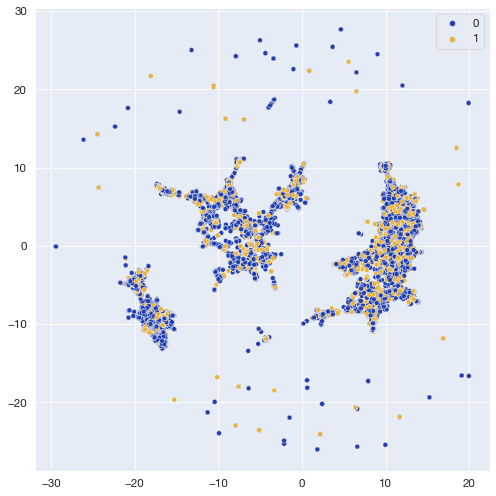

In [ ]:
embedding_pac_y(days,concat_var_,demo,path,"i")

# Functions

In [ ]:

def eda_embedding(path,namep_,concat_var_,fichero):
    if fichero != 'sin_codigo.csv':
        filtered_columns,max_sum_icd9codes,filtered_columns_icd9codes = top_predictors(concat_var_,10,"sum")
        cols1 = [i for i in filtered_columns_icd9codes if i !=days +"_READMIT"]
        #PACMAP EMBEDDING CONSITHEINGT HE COLUMNS THAT ARE MOS 
        X_transformed = pac_embeddng(filtered_columns_icd9codes[cols1],filtered_columns_icd9codes,path,namep_)

        #kernel density for created embeddings
        aux = create_df(X_transformed,filtered_columns_icd9codes)
        kernel_density_plot("X1",aux,'Kernel Density Plot for Admission vs. No Admission',path,namep_)
        kernel_density_plot("X2",aux,'Kernel Density Plot for Admission vs. No Admission',path,namep_)

        embedding_pac_y(days,concat_var_,"FALSE",path,namep_)   
     
def per_readmission(y):
    H1_num = y.sum().values[0]
    H0_num = (y.shape[0]-y.sum()).values[0]
    total_num = len(y.values[0])
    labels = days+' Days Readmission-Y', days+' Days Readmission-N'
    sizes = [H1_num/total_num*100, H0_num/total_num*100]
    colors = ['pink', 'skyblue']
    explode = (.05, 0)
    fig = plt.figure(figsize=(6,6))
    
    plt.pie(sizes, explode=explode, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.legend(labels, fontsize='small', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
    
    
#embeddings

def pac_embeddng(data,concat_var,path,name_p):
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 

    # fit the data (The index of transformed data corresponds to the index of the original data)
    X_transformed = embedding.fit_transform(data, init="pca")
    #X_transformed.shape
    cm = plt.cm.plasma.copy()
    cm.set_bad(color='gray')
    cm

    plt.figure(figsize = (7,7))
    sns.scatterplot(x = X_transformed[:,0], 
                y = X_transformed[:,1],
                hue = concat_var[days+"_READMIT"].values,
                #palette=cm
                );    
    plt.tight_layout()
    plt.savefig(path+name_p+"_pac_embeddingconsidering_7_top_features.png")

    
    return X_transformed
    
def embedding_pac_y(days,concat_var_,demo,path,name_p):
    '''funcion que te da reduce de dimension data y te da embedding de X, toma en cuenta unicament los ICD9-codes'''
    if demo == True:
        
        data = concat_var_.drop(["HADM_ID","SUBJECT_ID",days+'_READMIT','L_1s_last','Unnamed: 0','L_1s_last_p1'], axis=1)
    else:
        data = concat_var_.drop(["HADM_ID","SUBJECT_ID",days+'_READMIT','L_1s_last','Unnamed: 0','L_1s_last_p1','Age_max', 'LOSRD_sum', 'LOSRD_avg','ADMITTIME', 'DISCHTIME',
       'ADMITTIME_RANK', 'MAX_ADMITTIME_RANK', 'NEXT_ADMITTIME', 'INTERVAL',
       'age_group', 'INTERVAL_group', 'INTERVAL_max_admitted'], axis=1)
    pac_embeddng(data,concat_var_,path,name_p +"total_var")    
    
   

    
def variables_predictoras(concat_var_,var):

    #X_aux = pd.read_csv(ejemplo_dir+fichero_x)
        
    #concat_var = pd.merge(X_aux, readmit_df, on=["HADM_ID","SUBJECT_ID"], how='left')
# Filtrar datos de admisión y readmisión
    admitted = concat_var_[concat_var_[days+"_READMIT"] == 0]
    readmitted = concat_var_[concat_var_[days+"_READMIT"] == 1]

    fig, ax = plt.subplots()

    # Histograma para los datos de admisión
    ax.hist(admitted[var].values, edgecolor='k', lw=0.1, alpha=0.7, label='No readmission')

    # Histograma para los datos de readmisión
    ax.hist(readmitted[var].values, edgecolor='k', lw=0.1, alpha=0.7, label='Readmitted')

    ax.legend()
    ax.set_xlabel('Length of stay')
    plt.show()    
    
    
def create_bins_fun(concat_var):
    '''we define bins and labes,for age group and interval grouñ'''

    bins = [0, 18, 30, 40, 50, 60, 100]  # Define the age intervals for bins

    # Create labels for the bins
    labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-100']  # Labels for each bin range

    # Use cut to create bins from the 'age' column
    concat_var['age_group'] = pd.cut(concat_var['Age_max'], bins=bins, labels=labels, right=False) 
    
    concat_var['INTERVAL'] = concat_var['INTERVAL'].fillna(0)
    
    #para grupo lenght of stay
    bins = [0, 25, 100, 400, 500, 700, 4107]  # Define the age intervals for bins

    # Create labels for the bins
    labels = ['0-25', '26-100', '101-401', '402-500', '501-700', '701-4107']  # Labels for each bin range

    # Use cut to create bins from the 'age' column
    concat_var['INTERVAL_group'] = pd.cut(concat_var['INTERVAL'], bins=bins, labels=labels, right=False)  # Assign each value to a bin
    # Assign each value to a bin
    
    # Create bins for max admitted 
    bins = [0, 3, 5, 20, 42, ]  # Define the age intervals for bins

    # Create labels for the bins
    labels = ['0-3', '4-5', '6-20', '21-42']  # Labels for each bin range

    # Use cut to create bins from the 'age' column
    concat_var['INTERVAL_max_admitted'] = pd.cut(concat_var['MAX_ADMITTIME_RANK'], bins=bins, labels=labels, right=False)  # Assign each value to a bin

    return concat_var





def funcion_histograma_porotra_variable(concat_var,var_despliegue,var_ejex,x_label,title,y_label):
    '''concat_var; input datafram
    var_despliegue: variable que se muestra categorias
    var_ejex: nombre de variable en eje X
    x_label: label X
    title: titulo de grafica
    y_label: etiqueta y'''
    
    fig, ax = plt.subplots(figsize=(10,5))

    for i in concat_var[var_despliegue].unique():
        data_group = concat_var[concat_var[var_despliegue] == i]
        ax.hist(data_group[var_ejex], bins=20, alpha=0.8, label=i)

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()

    plt.tight_layout()
    plt.show()
    
    
def proporcion_dos_var(col_var,index_var,concat_var,title, y_label,x_label):
    '''funco que muestra la variable objetivo contra una variable categorica su proporcion
    input;
    col_var: es la variable categorica
    index_var: variables binaroa respuesta
    
    '''
    tmp = concat_var.\
        groupby([index_var,col_var]).agg(personas=('SUBJECT_ID','count')).\
        reset_index().pivot(index=index_var,columns=col_var,values='personas').replace(np.nan,0).\
        reset_index()

    gens =  list(concat_var[col_var].unique())
    data = np.zeros(shape=(len(gens),len(tmp.columns)-1))
    for i,sexo in enumerate(list(tmp[index_var].unique())):
        data[i,:] = tmp[tmp[index_var]==sexo][gens].values/\
            tmp[tmp[index_var]==sexo][gens].values.sum()

    fig,ax=plt.subplots()

    y = np.linspace(1,len(gens),len(gens))

    # mujeres
    ax.barh(y, -data[0,:], height=0.8,
            edgecolor='k',label='0')
    # hombres
    ax.barh(y, data[1,:], height=0.8,
        edgecolor='k', label='1')

    ax.set_yticks(y)
    ax.set_yticklabels(gens)
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    # cambiamos columnas izquierdas a positivas
    xs = ax.get_xticks()
    #x = np.linspace(-np.max(np.abs(xs)),np.max(np.abs(xs)),4)
    #ax.set_xticks(x)
    #ax.set_xticklabels(abs(x))

    x = np.linspace(-np.max(np.abs(xs)), np.max(np.abs(xs)), 5)
    ax.set_xticks(x)
    ax.set_xticklabels([f'{abs(val):.2f}' for val in x])  # Set the labels for ticks



    ax.legend(loc='center left',bbox_to_anchor=(1,0.5))
    ax.grid(axis='y')

    plt.tight_layout()
    #plt.savefig('outs/eda2k/demografico_prop_sexo_gen_knwn.png')

    plt.show()
    plt.close()    
    
    
def top_predictors(concat_var,num,mann):
    '''it return you the top n predictors'''
    #max_sum_icd9codes,top n columnas de acuerdo a su suma o mean
    #ffiltered_columns columnas con valor numerico de datafram
    #filtered_columns_icd9codes es la concatenacion de top columnas mas las variable objetivo


    num_list = []

    # Convertir 'Unnamed: 0' a número con errors='coerce'
    for i in concat_var.columns:
        converted_value = pd.to_numeric(i, errors='coerce')

        # Verificar si el valor convertido no es NaN y agregarlo a la lista
        if not np.isnan(converted_value):
            num_list.append(str(converted_value))
            
    filtered_columns = concat_var.filter(num_list)
    if mann == "sum":
       column_sums = filtered_columns.sum()
    elif mann ==   "mean":
        column_sums = filtered_columns.mean()
    max_sum_icd9codes = column_sums.sort_values(ascending=False).iloc[:num].index
    column_sums.sort_values(ascending=False)[:10]
    filtered_columns_icd9codes = concat_var.filter(list(max_sum_icd9codes) +[days+"_READMIT"])
    return filtered_columns,max_sum_icd9codes,filtered_columns_icd9codes
        #print(num_list)  # Imprimir la lista (si el valor no es NaN, se agregará a la lista)""
        
def create_df(X_transformed,filtered_columns_icd9codes):
    concat_var_ = pd.concat([pd.DataFrame(X_transformed),filtered_columns_icd9codes[[days+"_READMIT"]]],axis = 1)

    concat_var_ =  concat_var_.rename(columns={0:"X1"})
    concat_var_ =  concat_var_.rename(columns={1:"X2"})
    return concat_var_        

def kernel_density_plot(var,concat_var,title,path,name_p):
    admitted = concat_var[concat_var[days+'_READMIT'] == 1]
    not_admitted = concat_var[concat_var[days+'_READMIT'] == 0]

    # Create KDE plots for both categories
    sns.kdeplot(admitted[var], label='Admission', shade=True)
    sns.kdeplot(not_admitted[var], label='No Admission', shade=True)

    # Customize the plot
    plt.title(title)
    plt.xlabel(var)
    plt.ylabel('Density')

    # Show the legend
    plt.legend()
    
    # Show the plotplt.savefig(path+name_p+var+"_kernel_desnity.png")
    plt.tight_layout()
    plt.savefig(path+name_p+var+"_kernel_desnity.png")
    plt.show()    
    


# Logistic Regression one vs one

## Variables demograficas

In [ ]:
# Logistic Regression by variable

def var_demos(demo,concat_var):
    # Assuming 'target_variable' is your response variable
    # 'data' is your DataFrame containing all independent variables
    error_df = {'Variable':[],'Training Error':[], 'Test Error':[],
                'sensitivity_test':[],
                'specificity_test':[],
                'precision_test':[],
                'accuracy_test':[],
                  'sensitivity_train':[],
                'specificity_train':[],
                'precision_train':[],
                'accuracy_train':[],

                
        }
    for col in demo:
        if col != days+'_READMIT':
            # X is the predictor variable (independent variable)
            X = concat_var[[col]]

            # Y is the response variable (dependent variable)
            y = concat_var[[days+'_READMIT']]

            # Initialize the logistic regression model
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            
            # Inicializar y entrenar el modelo de regresión logística
            model = LogisticRegression()
            model.fit(X_train, y_train)

            # Realizar predicciones para los conjuntos de entrenamiento y prueba
            train_predictions = model.predict(X_train)
            test_predictions = model.predict(X_test)

            # Calcular los errores de entrenamiento y prueba y guardarlos en el DataFrame
            train_error = 1 - accuracy_score(y_train, train_predictions)
            test_error = 1 - accuracy_score(y_test, test_predictions)
            
            rf_conf = confusion_matrix(y_test, test_predictions)
            tn, fp, fn, tp = rf_conf.ravel()
            rf_sen = tp/(tp+fn)
            rf_spe = tn/(tn+fp)
            rf_prec = tp/(tp+fp)
            rf_acc = (tp+tn)/(tp+tn+fp+fn)
            
            rf_conf_t = confusion_matrix(y_train, train_predictions)
            tn_t, fp_t, fn_t, tp_t = rf_conf.ravel()
            rf_sen_t = tp_t/(tp_t+fn_t)
            rf_spe_t = tn_t/(tn_t+fp_t)
            rf_prec_t = tp_t/(tp_t+fp_t)
            rf_acc_t = (tp_t+tn_t)/(tp_t+tn_t+fp_t+fn_t)

            error_df["Training Error" ].append(train_error)
            error_df['Test Error'].append(test_error) 
            error_df['Variable'].append(col)
            error_df['sensitivity_test'].append(rf_sen)
            error_df['specificity_test'].append(rf_spe)
            error_df['precision_test'].append(rf_prec)
            error_df['accuracy_test'].append(rf_acc)
            error_df['sensitivity_train'].append(rf_sen_t)
            error_df['specificity_train'].append(rf_spe_t)
            error_df['precision_train'].append(rf_prec_t)
            error_df['accuracy_train'].append(rf_acc_t)
            

            # Mostrar el DataFrame con los errores de entrenamiento y prueba
    print(error_df)

    return pd.DataFrame(error_df)


In [ ]:
col_d =[ 'Age_max', 'LOSRD_sum','LOSRD_avg',  
    ]
var_demos(col_d,concat_var_)

{'Variable': ['Age_max', 'LOSRD_sum', 'LOSRD_avg'], 'Training Error': [0.1811239620403321, 0.18134638196915775, 0.18119810201660735], 'Test Error': [0.16992882562277578, 0.17022538552787658, 0.17022538552787658], 'sensitivity_test': [0.0, 0.0, 0.0], 'specificity_test': [1.0, 0.9996427295462665, 0.9996427295462665], 'precision_test': [nan, 0.0, 0.0], 'accuracy_test': [0.8300711743772242, 0.8297746144721234, 0.8297746144721234], 'sensitivity_train': [0.0, 0.0, 0.0], 'specificity_train': [1.0, 0.9996427295462665, 0.9996427295462665], 'precision_train': [nan, 0.0, 0.0], 'accuracy_train': [0.8300711743772242, 0.8297746144721234, 0.8297746144721234]}


,Variable,Training Error,Test Error,sensitivity_test,specificity_test,precision_test,accuracy_test,sensitivity_train,specificity_train,precision_train,accuracy_train
0,Age_max,0.181124,0.169929,0.0,1.000000,NaN,0.830071,0.0,1.000000,NaN,0.830071
1,LOSRD_sum,0.181346,0.170225,0.0,0.999643,0.0,0.829775,0.0,0.999643,0.0,0.829775
2,LOSRD_avg,0.181198,0.170225,0.0,0.999643,0.0,0.829775,0.0,0.999643,0.0,0.829775


## Variables X1, X2

In [ ]:
aux = create_df(X_transformed,filtered_columns_icd9codes)

col_d =[ "X1","X2"  
    ]
var_demos(col_d,aux)

{'Variable': ['X1', 'X2'], 'Training Error': [0.1811239620403321, 0.1811239620403321], 'Test Error': [0.16992882562277578, 0.16992882562277578], 'sensitivity_test': [0.0, 0.0], 'specificity_test': [1.0, 1.0], 'precision_test': [nan, nan], 'accuracy_test': [0.8300711743772242, 0.8300711743772242], 'sensitivity_train': [0.0, 0.0], 'specificity_train': [1.0, 1.0], 'precision_train': [nan, nan], 'accuracy_train': [0.8300711743772242, 0.8300711743772242]}


,Variable,Training Error,Test Error,sensitivity_test,specificity_test,precision_test,accuracy_test,sensitivity_train,specificity_train,precision_train,accuracy_train
0,X1,0.181124,0.169929,0.0,1.0,NaN,0.830071,0.0,1.0,NaN,0.830071
1,X2,0.181124,0.169929,0.0,1.0,NaN,0.830071,0.0,1.0,NaN,0.830071


#  Modeling


In [ ]:



def function_models(model, sampling,li_feature_selection,kfolds,lw,K,type_reg):
    '''function that trains the predictive model, it is able to stratifi splits the input, it 
    also take sin acounts wtih selection of variables, ussing logistic regression with penanlty l1, '''
    '''
    Inputs:
    model: type of model that will be traines
    sampling: the valid option is under sampling (under), over sampling (over)
    li_feature_selection: if its true it selec features fitting a logistic regression with
    penalty l1, it select features according to importance weights
    kfolds: there are two type of folds, stratified where the classes preserve the percentage
    of samples for each class otherwise it splits dataset in different consecutive folds. 
    K: number of splits to be considered
    output:
    sensitivity;number of true postives /(number of true postives  of false positives plus the number of false positives)
    specificity: true negative /(true negative+false positives)
    precision: number of true postives /(number of true postives  of false positives plus the number of false negatives)
    accuracy; number of correc prediccition/ total number of prediction
    f1_score: it is the armonic mean of precision and recall 
    '''
    #obtain the kfolfs/ stratifies or consecutive
    if kfolds == "strati":
       skf = StratifiedKFold(n_splits=K, shuffle=False, )
    else:   
       skf = KFold(K, shuffle=False,)
    #initializiate lists   
    y_true = []
    y_pred = []
    y_true_train   =[]
    y_pred_train =[]
     
   #plot figures   
    fig = plt.figure(figsize=(7,7))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    roc_aucs_xgb1 = []
    #split train in folds
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # l1-based feature selection
        if li_feature_selection == True:
            if type_reg =="logistic":
                logit_clf = LogisticRegression(penalty='l1', random_state=0, solver='liblinear')
            elif type_reg =="lasso":
                
                logit_clf = Lasso(alpha=0.001, random_state=10)
                cross_val_scores = cross_val_score(logit_clf, X_train, y_train, cv=5, scoring='accuracy')  # Adjust the scoring metric as needed

            logit_clf.fit(X_train, y_train)
            select_model = SelectFromModel(logit_clf)
            select_model.fit(X_train, y_train)
            X_train_new = select_model.transform(X_train)
            X_test_new = select_model.transform(X_test)
        else:
            X_train_new = X_train
            X_test_new = X_test    
        
        #the Xtrainfolds and Xtest folds are considered 
        rf_clf = model
        #the underspling or over samplinf its performed,or not.
        
        if sampling == "under":
            #it undersampls
            rus = RandomUnderSampler(random_state=42)
            
            X_train_rus, y_train_rus = rus.fit_resample(X_train_new, y_train)
            #trains the model, with the under sampled
            rf_clf.fit(X_train_rus, y_train_rus)
            #predict with normal test set as it is under sampled is only needed in train set
            y_pred_sub = rf_clf.predict(X_test_new)
            # it appends it tu the true y_test foldslist
            y_true = np.append(y_true, y_test)
            y_pred = np.append(y_pred, y_pred_sub)
            #it predict with x_train it is no ovesamples
            y_pred_sub_train = rf_clf.predict(X_train_rus)
            #it appends in training set and the predixtion of trainif ser
            y_true_train = np.append(y_true_train, y_train_rus)
            y_pred_train = np.append(y_pred_train, y_pred_sub_train)
 
        elif sampling == "over":
            #over samples
            ros = RandomOverSampler(random_state=42)
            
            X_train_ros, y_train_ros = ros.fit_resample(X_train_new, y_train)
            #it train the model with over sampled
            rf_clf.fit(X_train_ros, y_train_ros)
            #it is predictred with testing set not over sampled
            y_pred_sub = rf_clf.predict(X_test_new)
            y_true = np.append(y_true, y_test)
            y_pred = np.append(y_pred, y_pred_sub)
            # in the cas of training it predict with no oversampled trainning dataset
            y_pred_sub_train = rf_clf.predict(X_train_ros)
            #it appends it 
            y_true_train = np.append(y_true_train, y_train_ros)
            y_pred_train = np.append(y_pred_train, y_pred_sub_train)
        else:    
            #train the model 
            rf_clf.fit(X_train_new, y_train)
            #predict with test to obtain the test set error
            y_pred_sub = rf_clf.predict(X_test_new)
            y_true = np.append(y_true, y_test)
            y_pred = np.append(y_pred, y_pred_sub)
            #it prdic with train to obtain the trainig error
            y_pred_sub_train = rf_clf.predict(X_train_new)
            y_true_train = np.append(y_true_train, y_train)
            y_pred_train = np.append(y_pred_train, y_pred_sub_train)
            
        try:
            xgb1_pred_prob = rf_clf.predict_proba(X_test_new)
            xgb1_pred_prob = rf_clf.predict_proba(X_test_new)
            fpr, tpr, thresholds = roc_curve(y_test, xgb1_pred_prob[:, 1])
            mean_tpr += interp(mean_fpr, fpr, tpr)
            mean_tpr[0] = 0.0
            roc_auc = auc(fpr, tpr)
            roc_aucs_xgb1.append(roc_auc)
            #plt.plot(fpr, tpr, lw=2, label='ROC fold (area = %0.2f)' % (roc_auc))
            roc_res = "Yes"  
            mean_auc_ = np.mean(roc_aucs_xgb1)
            
        except:
            mean_auc_ = 0
            roc_res = "No"
            #obtain roc, and auc score
    if roc_res == "Yes":
        #plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
        #        label='Luck')

        mean_tpr /= K
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        #plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         #       label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

        #plt.xlim([-0.05, 1.05])
        #plt.ylim([-0.05, 1.05])
        #plt.xlabel('False Positive Rate')
        #plt.ylabel('True Positive Rate')
        #plt.title('Initial estimator ROC curve')
        #plt.legend(loc="lower right")       
    try:
        #it obtain metric considered and confussion matrix, metrics for the test set
        rf_conf = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = rf_conf.ravel()
        rf_sen = tp/(tp+fn)
        rf_spe = tn/(tn+fp)
        rf_prec = tp/(tp+fp)
        rf_acc = (tp+tn)/(tp+tn+fp+fn)
        f1 = f1_score(y_true, y_pred, average='macro')
        #metrics for the training set
        rf_conf_t = confusion_matrix(y_true_train, y_pred_train)
        tn_t, fp_t, fn_t, tp_t = rf_conf_t.ravel()
        rf_sen_t = tp_t/(tp_t+fn_t)
        rf_spe_t = tn_t/(tn_t+fp_t)
        rf_prec_t = tp_t/(tp_t+fp_t)
        rf_acc_t = (tp_t+tn_t)/(tp_t+tn_t+fp_t+fn_t)
        f1_t = f1_score(y_true_train, y_pred_train, average='macro')
    except:
        rf_conf = 0
        tn, fp, fn, tp = 0,0,0,0
        rf_sen = 0
        rf_spe = 0
        rf_prec = 0
        rf_acc = 0
        f1 = 0
        
        rf_conf_t = 0
        tn_t, fp_t, fn_t, tp_t = 0,0,0,0
        rf_sen_t = 0
        rf_spe_t = 0
        rf_prec_t = 0
        rf_acc_t = 0
        f1_t = 0


    
    return rf_sen,rf_spe,rf_prec,rf_acc,mean_auc_,rf_conf,rf_sen_t,rf_spe_t,rf_prec_t,rf_acc_t,f1,f1_t
    

In [ ]:


def modelo_df(X,y,name_p,type_reg):
    #BaggingClassifier(KNeighborsClassifier(),max_samples=0.5, max_features=0.5),
    #model =[RandomForestClassifier(n_estimators=100, max_depth=3),LogisticRegression(penalty='l1', random_state=0, solver='liblinear'), XGBClassifier()]
    model =[LogisticRegression(penalty='l1', random_state=0, solver='liblinear'), XGBClassifier()]
    #
    result = {              'f1_test':[],
                'f1_train':[],
   
                'sensitivity_test':[],
                'specificity_test':[],
                'precision_test':[],
                'accuracy_test':[],
                'sensitivity_train':[],
                'specificity_train':[],
                'precision_train':[],
                'accuracy_train':[],
              
                'confusion matrix':[],
                'Sampling':[],
                'Feature selection':[],
                'Classifiers':[],
                'Mapping':[],
            
            
            }               
    #strati = ["strati","non"] 
    #sampling = ["non","under","over"]
    sampling = ["non","over"]
    
    li_feature_selection = [False,True]
    li_feature_selection = ["lasso"]
    kfolds = 5

    #k
    lw = 2
    K = 5

    for i in tqdm(model):
        model_name = i.__class__.__name__
    
        for j in sampling:
            for k1 in li_feature_selection:
                
                
                
                rf_sen,rf_spe,rf_prec,rf_acc,mean_auc_,rf_conf,rf_sen_t,rf_spe_t,rf_prec_t,rf_acc_t,f1,f1_t = function_models(i, sampling,li_feature_selection,kfolds,lw,K,type_reg)
             
              
               
                result['sensitivity_test'].append(rf_sen)
                result['specificity_test'].append(rf_spe)
                result['precision_test'].append(rf_prec)
                result['accuracy_test'].append(rf_acc)
                result['sensitivity_train'].append(rf_sen_t)
                result['specificity_train'].append(rf_spe_t)
                result['precision_train'].append(rf_prec_t)
                result['accuracy_train'].append(rf_acc_t)
                result['f1_test'].append(f1)
                result['f1_train'].append(f1_t)
                result['confusion matrix'].append(rf_conf)
                result['Sampling'].append(j)
                result['Feature selection'].append(k1)
                result['Classifiers'].append(model_name)
                result['Mapping'].append(name_p)
               
                
                    
    df_res = pd.DataFrame(result)
    return df_res              
                    

# Codigo para obtener iteración de modelos/ var inputs

In [992]:
import os
ejemplo_dir = '/Users/cgarciay/Desktop/Laval_Master_Computer/research/input_model_pred/'
path = "/Users/cgarciay/Desktop/Laval_Master_Computer/research/results_pred/images/class_matrix_var_res/"
days = "180"
fichero_y ="label_"+days+"j.csv"
prepro = "std"
ficheros = read_director(ejemplo_dir)
readmit_df = label_fun(days)
kfolds = 5
type_reg = "lasso"



['sin_codigo.csv', 'cat_threshold .999 most frequent.csv', '.DS_Store', 'cat_threshold .98 most frequent.csv', 'cat_threshold .95 most frequent_proc.csv', 'cat_threshold .88 most frequent.csv', 'ICD9_CODE_procedures.csv', 'CCS CODES_proc.csv']
(12456, 8)


  0%|          | 0/7 [00:00<?, ?it/s]

sin_codigo.csv
non
(16860, 9)


[07:16:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:16:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:16:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:16:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

 14%|█▍        | 1/7 [00:05<00:32,  5.41s/it]

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

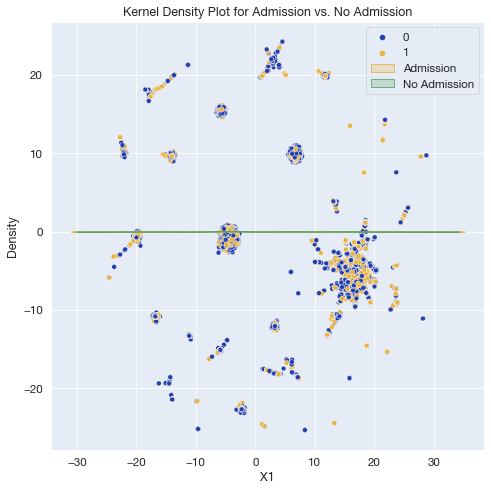

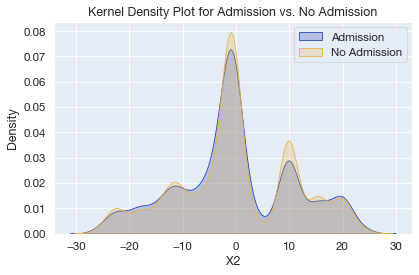

cat_threshold .999 most frequent.csv
std
(16860, 1430)
[[-0.06095445 -0.01089211 -0.04360725 ... -0.85366018 -0.37798548
  -0.58685245]
 [-0.06095445 -0.01089211 -0.04360725 ... -0.87382775 -0.37798548
  -0.58685245]
 [-0.06095445 -0.01089211 -0.04360725 ...  1.340662    0.37051784
   0.12264473]
 ...
 [-0.06095445 -0.01089211 -0.04360725 ...  0.11241173 -0.40917312
  -0.42918641]
 [-0.06095445 -0.01089211 -0.04360725 ...  0.10664957 -0.33640196
  -0.11385433]
 [-0.06095445 -0.01089211 -0.04360725 ...  0.11878043 -0.34679784
  -0.42918641]]
(16860, 1424)


[07:17:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:18:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:18:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:18:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

 29%|██▊       | 2/7 [05:04<14:50, 178.05s/it]

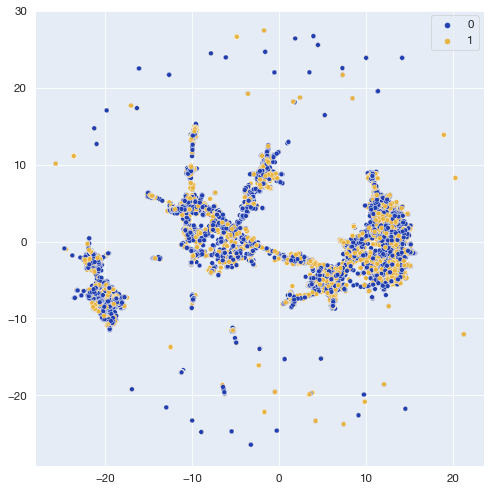

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

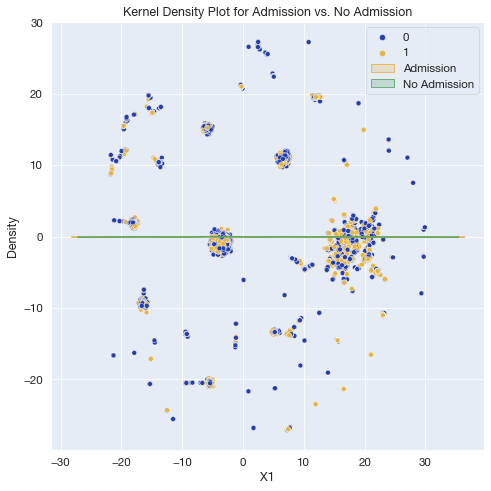

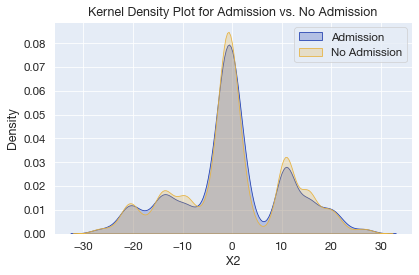

cat_threshold .98 most frequent.csv
power
(16860, 706)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 700)
(16860, 7

[07:22:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:22:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:23:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:23:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

 43%|████▎     | 3/7 [08:06<12:00, 180.08s/it]

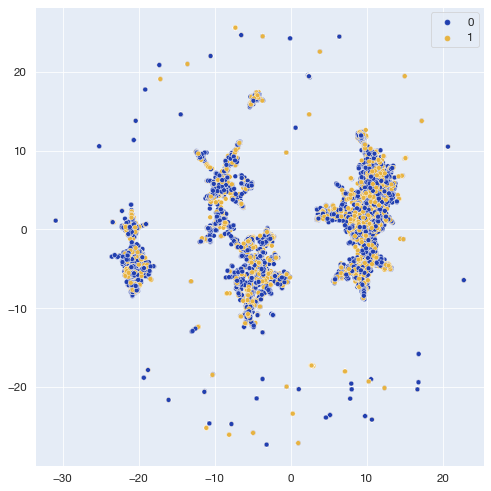

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

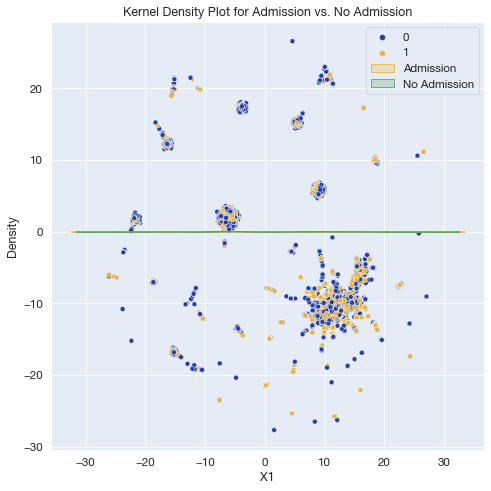

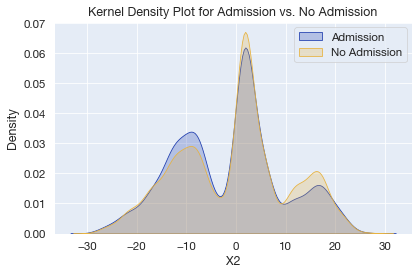

cat_threshold .95 most frequent_proc.csv
std
(16860, 437)
[[-0.35317134 -0.04360725 -0.03082034 ... -0.85366018 -0.37798548
  -0.58685245]
 [-0.35317134 -0.04360725 -0.03082034 ... -0.87382775 -0.37798548
  -0.58685245]
 [-0.35317134 -0.04360725 -0.03082034 ...  1.340662    0.37051784
   0.12264473]
 ...
 [-0.35317134 -0.04360725 -0.03082034 ...  0.11241173 -0.40917312
  -0.42918641]
 [ 1.14292634 -0.04360725 -0.03082034 ...  0.10664957 -0.33640196
  -0.11385433]
 [-0.35317134 -0.04360725 -0.03082034 ...  0.11878043 -0.34679784
  -0.42918641]]
(16860, 431)


[07:25:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:25:18] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:25:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:25:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

 57%|█████▋    | 4/7 [09:58<07:39, 153.17s/it]

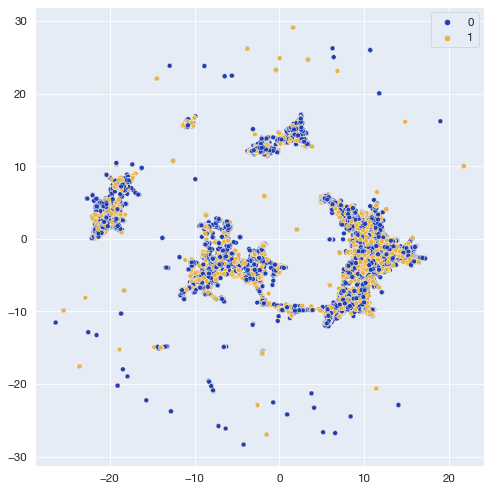

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

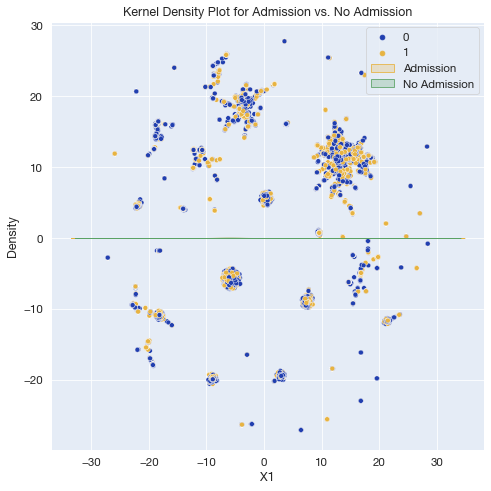

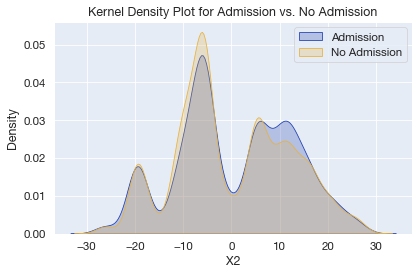

cat_threshold .88 most frequent.csv
power
(16860, 229)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 223)
(16860, 2

[07:26:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:27:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:27:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:27:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

 71%|███████▏  | 5/7 [11:08<04:06, 123.12s/it]

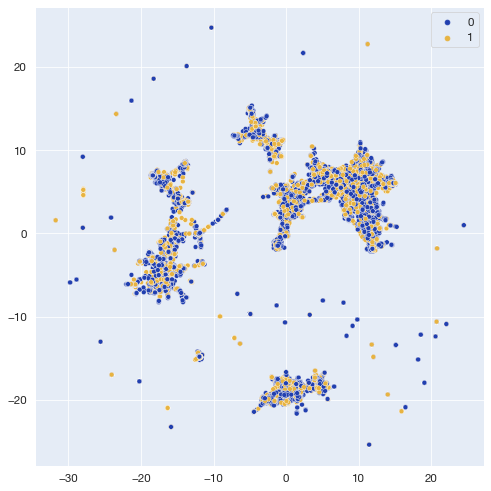

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

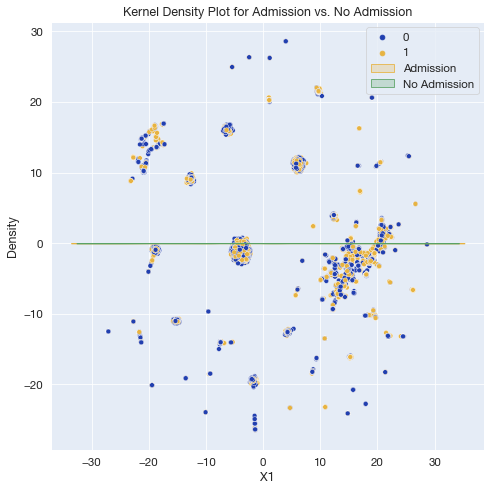

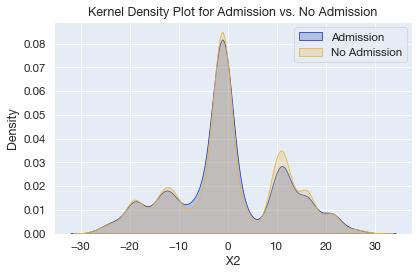

ICD9_CODE_procedures.csv
std
(16860, 1505)
[[-0.01089211 -0.04360725 -0.03082034 ... -0.85366018 -0.37798548
  -0.58685245]
 [-0.01089211 -0.04360725 -0.03082034 ... -0.87382775 -0.37798548
  -0.58685245]
 [-0.01089211 -0.04360725 -0.03082034 ...  1.340662    0.37051784
   0.12264473]
 ...
 [-0.01089211 -0.04360725 -0.03082034 ...  0.11241173 -0.40917312
  -0.42918641]
 [-0.01089211 -0.04360725 -0.03082034 ...  0.10664957 -0.33640196
  -0.11385433]
 [-0.01089211 -0.04360725 -0.03082034 ...  0.11878043 -0.34679784
  -0.42918641]]
(16860, 1499)


[07:29:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:29:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:29:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:30:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

 86%|████████▌ | 6/7 [16:49<03:17, 197.17s/it]

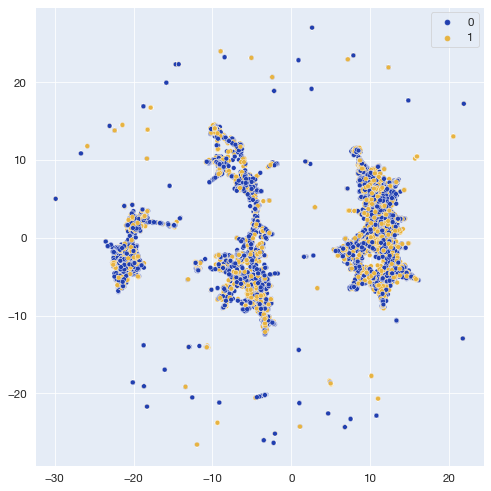

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

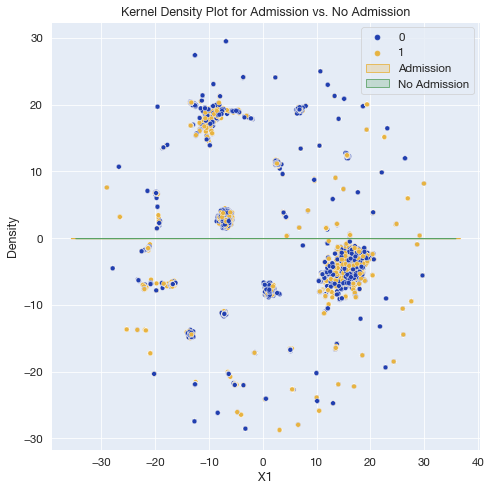

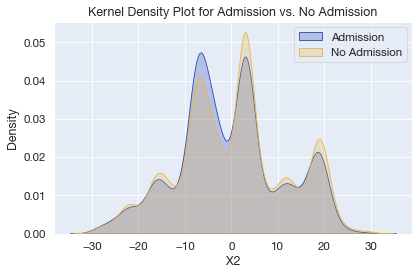

CCS CODES_proc.csv
std
(16860, 216)
[[-0.17146717 -0.06967557 -0.07804901 ... -0.85366018 -0.37798548
  -0.58685245]
 [-0.17146717 -0.06967557 -0.07804901 ... -0.87382775 -0.37798548
  -0.58685245]
 [-0.17146717 -0.06967557 -0.07804901 ...  1.340662    0.37051784
   0.12264473]
 ...
 [-0.17146717 -0.06967557 -0.07804901 ...  0.11241173 -0.40917312
  -0.42918641]
 [-0.17146717 -0.06967557 -0.07804901 ...  0.10664957 -0.33640196
  -0.11385433]
 [-0.17146717 -0.06967557 -0.07804901 ...  0.11878043 -0.34679784
  -0.42918641]]
(16860, 210)


[07:33:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:33:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:33:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:33:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

100%|██████████| 7/7 [17:51<00:00, 153.07s/it]


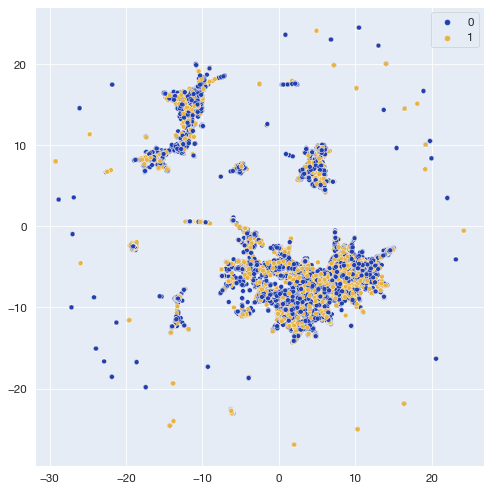

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 504x504 with 0 Axes>

In [993]:
# Se obtiene dataframe que sera el output del perfomance del entrenamiento
df_res_aux = pd.DataFrame(columns=[ ])
# se obtiene el respectivo preprocesing de acuerdo al experimento que se realizo
for i in tqdm(ficheros):
    concat_var_ = create_var(ejemplo_dir,i)
    eda_embedding(path,i,concat_var_,i)
    
    print(i)
    if i in ['ICD9_CODE_procedures.csv', 'CCS CODES_proc.csv', 'cat_threshold .95 most frequent_proc.csv', 'cat_threshold .999 most frequent.csv']:
        prepo = "std"
    elif i in ['cat_threshold .88 most frequent.csv', 'cat_threshold .98 most frequent.csv']:
        prepo = "power"
    else:
        prepo = "non"
    print(prepo)
        # se obtiene la matriz de features y la variable response
    
    X,y ,concat_var  = lectura_variables(readmit_df,i,fichero_y,prepo,ejemplo_dir,days)
    try:
        X = X.values
        
    except:
        pass   
    try:
        y = y[days +"_READMIT"].to_numpy()
    except:
        y = y
    
    # funcion de entrenamiento dem odelo
    df_res = modelo_df(X,y,i,type_reg)
    
    #concatenación de dataframes 
    df_res_aux = pd.concat([df_res_aux,df_res])
    
# se guarda dataframes    
df_res_aux.to_csv("/Users/cgarciay/Desktop/Laval_Master_Computer/research/results_pred/results_prediction_"+days+"+_realv2.csv")   

In [987]:
df_res_aux

,f1_test,f1_train,sensitivity_test,specificity_test,precision_test,accuracy_test,sensitivity_train,specificity_train,precision_train,accuracy_train,confusion matrix,Sampling,Feature selection,Classifiers,Mapping
0,0.451124,0.451465,0.000332,0.999567,0.142857,0.820819,0.000663,0.999549,0.242424,0.820863,"[[13838, 6], [3015, 1]]",non,lasso,LogisticRegression,sin_codigo.csv
1,0.451124,0.451465,0.000332,0.999567,0.142857,0.820819,0.000663,0.999549,0.242424,0.820863,"[[13838, 6], [3015, 1]]",over,lasso,LogisticRegression,sin_codigo.csv
2,0.519993,0.596411,0.077255,0.988804,0.600515,0.825741,0.162052,0.998465,0.958333,0.848843,"[[13689, 155], [2783, 233]]",non,lasso,XGBClassifier,sin_codigo.csv
3,0.519993,0.596411,0.077255,0.988804,0.600515,0.825741,0.162052,0.998465,0.958333,0.848843,"[[13689, 155], [2783, 233]]",over,lasso,XGBClassifier,sin_codigo.csv


In [ ]:
df_res_aux.to_csv("/Users/cgarciay/Desktop/Laval_Master_Computer/research/results_pred/results_prediction_"+days+"+_real.csv")   